In [1]:
import matplotlib.pyplot as plt
import control
import torch
import numpy as np
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import DataLoader
from torch import nn
from net_identification_utils import FCnet, train, test, ControlDataset, plot_discrete_output, generate_data, hyper_search

In [2]:
system = control.TransferFunction(np.array([1, 0]), np.array([1, -7/12, 1/4, -1/24]), 1)

In [3]:
control.margin(system)

(0.625, 36.67860882036618, 0.0, 1.036960862501573)

In [4]:
train_dataset = generate_data(
    control_sys=system,
    impact_time=90,
    cooldown_time=10,
    n_signals=1000,                                                            # frequency range
    u_signal_generation_func=lambda x: np.sin(np.arange(x) * np.random.uniform(low=0.05, high=0.1)) / 2
)

In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)

In [6]:
model = FCnet(input_size=train_dataset[0][0].size()[0], output_size=train_dataset[0][1].size()[0], n_layers=5, hidden_size=50)

In [7]:
train(model, 50, train_dataloader, nn.MSELoss())

epoch 0, mse 0.06046559079550207
epoch 1, mse 0.0022897321166237814
epoch 2, mse 0.0005688343782094307
epoch 3, mse 0.00038309006369672714
epoch 4, mse 0.0002612563034199411
epoch 5, mse 0.00015465156982827466
epoch 6, mse 9.46271122302278e-05
epoch 7, mse 6.032866993336938e-05
epoch 8, mse 4.675111358665163e-05
epoch 9, mse 3.6090523717575704e-05
epoch 10, mse 4.7411117229785304e-05
epoch 11, mse 3.3754549622244665e-05
epoch 12, mse 2.753788219706621e-05
epoch 13, mse 3.0339136073962437e-05
epoch 14, mse 4.4027364292560375e-05
epoch 15, mse 2.709453414354357e-05
epoch 16, mse 2.453321219945792e-05
epoch 17, mse 0.00012077878483978565
epoch 18, mse 2.9360322550928685e-05
epoch 19, mse 1.2251817483956984e-05
epoch 20, mse 1.2989601755180047e-05
epoch 21, mse 2.191900403886393e-05
epoch 22, mse 2.6658476044758573e-05
epoch 23, mse 2.447598666549311e-05
epoch 24, mse 2.6224740850011585e-05
epoch 25, mse 2.247277992864838e-05
epoch 26, mse 7.820515445928323e-05
epoch 27, mse 4.263529558556

In [8]:
test_dataset = generate_data(
    control_sys=system,
    impact_time=90,
    cooldown_time=10,
    n_signals=1000,                                                            # frequency range
    u_signal_generation_func=lambda x: np.sin(np.arange(x) * np.random.uniform(low=0.05, high=0.1)) / 2
)

In [9]:
test_dataloader = DataLoader(test_dataset, batch_size=1)

среднее MSE для одного сигнала на сгенерированной тестовой выборке

In [10]:
test(model, test_dataloader, nn.MSELoss())

5.1246750379505104e-05

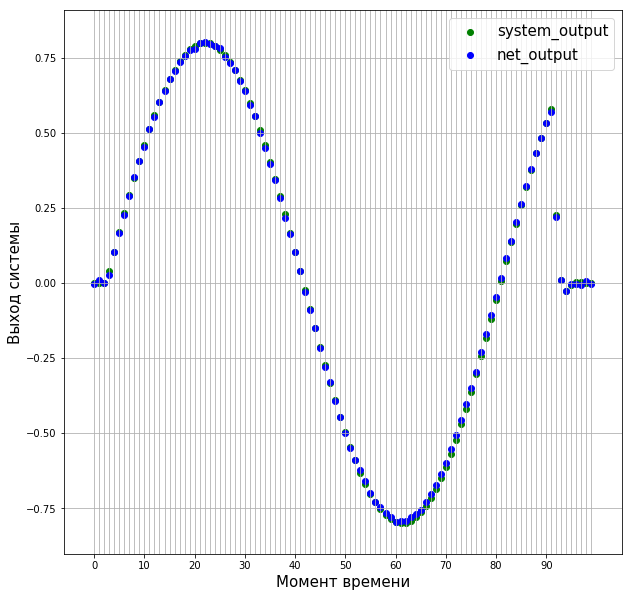

In [11]:
plot_discrete_output(
    system_output=test_dataset[2][1],
    net_output=model(test_dataset[2][0])
    # file_name='fcnet_prediction.png'
)
# actually perfect for simple system and not shifted test signal 
# (test signal frequency not shifted relative to train signal)

### prediction on input signal with shifted frequency relative to train data

In [8]:
test_dataset = generate_data(
    control_sys=system,
    impact_time=90,
    cooldown_time=10,
    n_signals=1000,                                                            # frequency range
    u_signal_generation_func=lambda x: np.sin(np.arange(x) * np.random.uniform(low=0.1, high=0.2)) / 2
)

In [8]:
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [14]:
test(model, test_dataloader, torch.nn.MSELoss())

0.20087960660313547

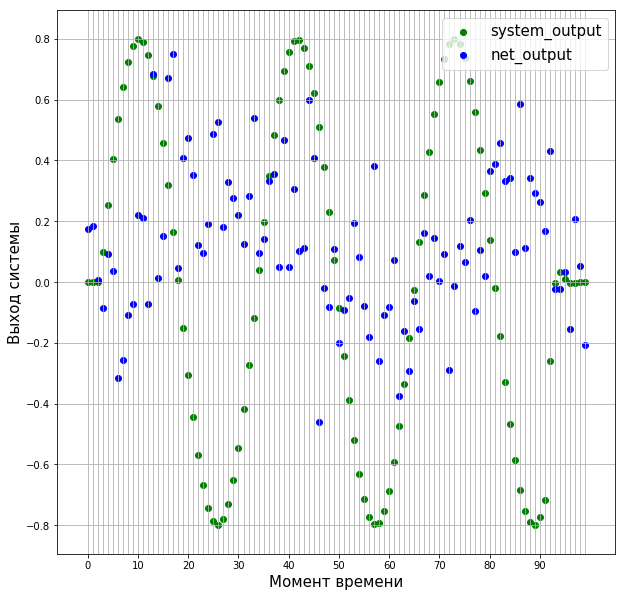

In [15]:
sample = generate_data(
    control_sys=system,
    impact_time=90,
    cooldown_time=10,
    n_signals=1,                                             # frequency
    u_signal_generation_func=lambda x: np.sin(np.arange(x) * 0.2) / 2
)
plot_discrete_output(
    system_output=sample[0][1],
    net_output=model(test_dataset[0][0]),
    # file_name='fcnet_prediction_shifted.png'
)
# prediction is not so relevant for high frequency (0.2)

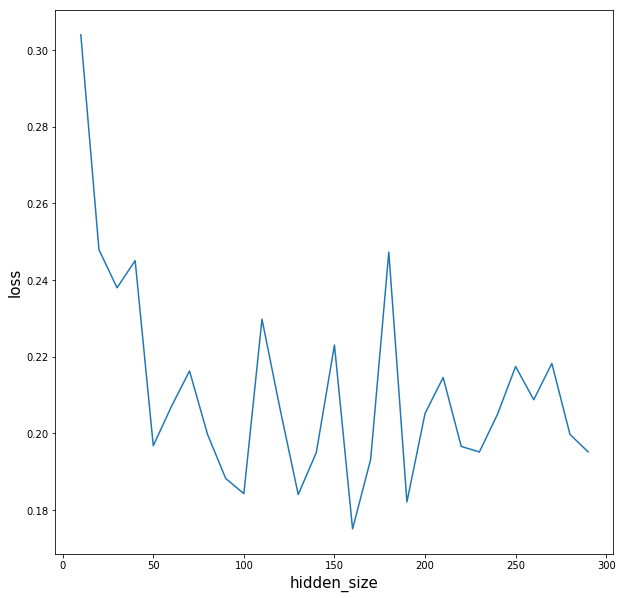

In [9]:
hyper_search(
    model_class=FCnet,
    train_dataloader=train_dataloader,
    test_dataset=test_dataset,
    default_init_args={
        'input_size': train_dataset[0][0].size()[0],
        'output_size': train_dataset[0][1].size()[0],
        'n_layers': 5,
        'hidden_size': 50
    },
    arg_variants={'hidden_size': np.arange(1, 30) * 10},
    train_epochs=50,
    plot_file_name='perceptron_hiddden_size_search.png'
)

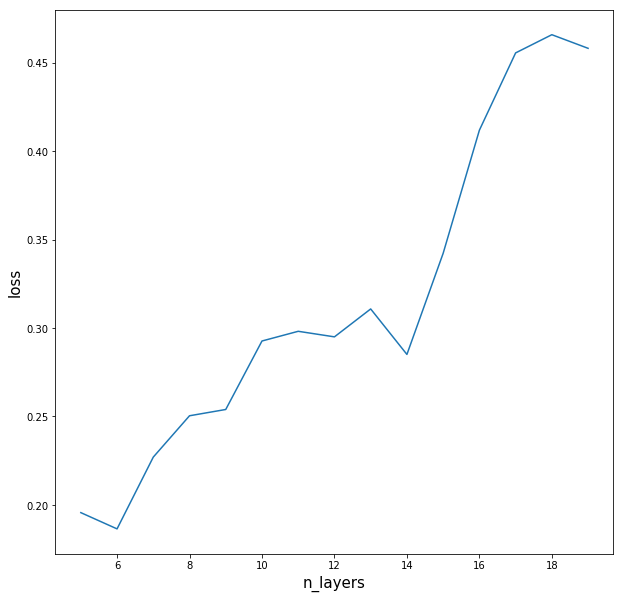

In [10]:
hyper_search(
    model_class=FCnet,
    train_dataloader=train_dataloader,
    test_dataset=test_dataset,
    default_init_args={
        'input_size': train_dataset[0][0].size()[0],
        'output_size': train_dataset[0][1].size()[0],
        'n_layers': 5,
        'hidden_size': 150
    },
    arg_variants={'n_layers': np.arange(5, 20)},
    train_epochs=50,
    plot_file_name='perceptron_n_layers_search.png'
)

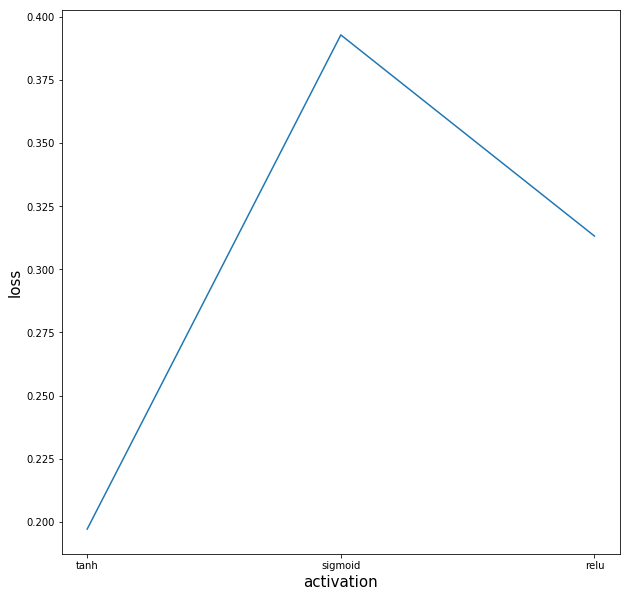

In [11]:
hyper_search(
    model_class=FCnet,
    train_dataloader=train_dataloader,
    test_dataset=test_dataset,
    default_init_args={
        'input_size': train_dataset[0][0].size()[0],
        'output_size': train_dataset[0][1].size()[0],
        'n_layers': 5,
        'hidden_size': 150
    },
    arg_variants={'activation': ['tanh', 'sigmoid', 'relu']},
    train_epochs=50,
    plot_file_name='perceptron_activation_search.png'
)